In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from google.colab import drive

%matplotlib inline
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/drive/MyDrive/Dataset.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [ ]:
df_sales = df.groupby(by=["C&FAgent", "Date"]).agg({"Sales": "sum"}).reset_index()

In [ ]:
# Calculate monthly APE for each C&FAgent.

df_2006 = df[(df["Date"].dt.year == 2006) & (df["Sales"] != 0)].copy()
df_2006["APE"] = abs(df_2006["Sales"] - df_2006["DemandForecast"]) / df_2006["Sales"] * 100
df_mape_monthly = df_2006.groupby(["C&FAgent", "Date"]).agg({"APE": "mean"})
df_mape_monthly

APE
C&FAgent       Date                  
Alabama Agent1 2006-01-01  103.201740
               2006-02-01   63.929816
               2006-03-01  129.187070
               2006-04-01   39.662489
               2006-05-01   56.902363
...                               ...
Texas Agent2   2006-08-01   73.637340
               2006-09-01   39.331795
               2006-10-01   61.928451
               2006-11-01  188.321836
               2006-12-01  606.610522

[347 rows x 1 columns]

In [ ]:
# Calculate yearly MAPE for each C&FAgent.

df_mape = df_2006.groupby("C&FAgent").agg({"APE": "mean"}).reset_index().rename(columns={"APE": "MAPE"})
df_mape

,C&FAgent,MAPE
0,Alabama Agent1,101.475956
1,Alabama Agent2,116.051129
2,Alabama Agent3,112.820729
3,California Agent1,97.541271
4,California Agent2,154.234268
5,Colorado Agent1,88.688754
6,Colorado Agent2,141.007858
7,Colorado Agent3,121.418387
8,Colorado Agent4,118.833510
9,Colorado Agent5,147.328159


from matplotlib import pyplot as plt
df_mape['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_mape['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df_total_sales = df.groupby("C&FAgent").agg({"Sales": "sum"}).reset_index()
df_total_sales

,C&FAgent,Sales
0,Alabama Agent1,60940838
1,Alabama Agent2,46147054
2,Alabama Agent3,19406093
3,California Agent1,35365379
4,California Agent2,4656928
5,Colorado Agent1,39339360
6,Colorado Agent2,19543433
7,Colorado Agent3,8416713
8,Colorado Agent4,21566941
9,Colorado Agent5,10790985


In [ ]:
# Calculate percentage sales of each product for every C&FAgent.

df_pivot = pd.pivot_table(df, values="Sales", index=["C&FAgent", "ProductCode"], aggfunc='sum').reset_index()
df_total_sales = df.groupby("C&FAgent").agg({"Sales": "sum"}).reset_index()
df_pctage = pd.merge(df_pivot, df_total_sales, on="C&FAgent").rename(columns={"Sales_x": "Sales", "Sales_y": "C&FAgent_Sales"})
df_pctage["Percentage"] = round(df_pctage["Sales"] / df_pctage["C&FAgent_Sales"] * 100, 2)
df_pctage

,C&FAgent,ProductCode,Sales,C&FAgent_Sales,Percentage
0,Alabama Agent1,15645,90275,60940838,0.15
1,Alabama Agent1,16220,69495,60940838,0.11
2,Alabama Agent1,17240,88218,60940838,0.14
3,Alabama Agent1,19875,24919,60940838,0.04
4,Alabama Agent1,19920,111250,60940838,0.18
...,...,...,...,...,...
812,Texas Agent2,95945,278,79606628,0.00
813,Texas Agent2,96500,17214,79606628,0.02
814,Texas Agent2,97533,199,79606628,0.00
815,Texas Agent2,98669,165,79606628,0.00


In [ ]:
def forecast_agent_sarimax(a, param):
  df_ts = df_sales[df_sales["C&FAgent"] == a].set_index("Date").asfreq("MS")
  model = sm.tsa.statespace.SARIMAX(df_ts["Sales"], order=param[:3], seasonal_order=param[3:]).fit()
  df_test = df_ts.copy()
  df_test = pd.concat([
      df_test,
      pd.DataFrame(
          {"Sales": [None]*12},
          index=pd.to_datetime(
              [f"2007-0{m}-01" if m < 10 else f"2007-{m}-01" for m in range(1, 13)],
              format="%Y-%m-%d"
          ))
      ])
  df_test["Forecast"] = model.predict (start=24, end=48, dynamic=True)
  df_test["Difference"] = df_test["Forecast"] - df_test["Sales"]
  mape = np.round(np.mean(np.abs(100 * (df_test["Forecast"] - df_test["Sales"]) / df_test["Sales"])), 0)
  df_test[["Sales", "Forecast"]].plot()
  df_test["Forecast"] = df_test["Forecast"].fillna(0).map(int)
  print("MAPE: ", f"{mape}%")
  return df_test[["Sales", "Forecast", "Difference"]]

In [ ]:
def forecast_agent_arima(a, param):
  df_ts = df_sales[df_sales["C&FAgent"] == a].set_index("Date").asfreq("MS")
  model = sm.tsa.statespace.SARIMAX(df_ts["Sales"], order=param).fit()
  df_test = df_ts.copy()
  df_test = pd.concat([
      df_test,
      pd.DataFrame(
          {"Sales": [None]*12},
          index=pd.to_datetime(
              [f"2007-0{m}-01" if m < 10 else f"2007-{m}-01" for m in range(1, 13)],
              format="%Y-%m-%d"
          ))
      ])
  df_test["Forecast"] = model.predict(start=24, end=48, dynamic=True)
  df_test["Difference"] = df_test["Forecast"] - df_test["Sales"]
  mape = np.round(np.mean(np.abs(100 * (df_test["Forecast"] - df_test["Sales"]) / df_test["Sales"])), 0)
  df_test[["Sales", "Forecast"]].plot()
  df_test["Forecast"] = df_test["Forecast"].fillna(0).map(int)
  print("MAPE: ", f"{mape}%")
  return df_test[["Sales", "Forecast", "Difference"]]

In [ ]:

def decompose_product_forecast(df, agent_name):
  df_t = df[df_a1["Forecast"] > 0]
  df_t = df_t.reset_index().rename(columns={"index": "Date"})
  df_pct = df_pctage[df_pctage['C&FAgent'] == agent_name][["ProductCode", "Percentage"]]
  df_t = df_t.merge(df_pct, how="cross")
  df_t["ProductForecast"] = df_t["Forecast"] * df_t["Percentage"] / 100
  return df_t[["Date", "ProductCode", "ProductForecast"]]

AD Fuller Tests

In [ ]:
adf = adfuller(df_sales[df_sales["C&FAgent"] == "Alabama Agent1"].set_index("Date").asfreq("MS")["Sales"])
pvalue = adf[1]
print("P value is:", pvalue)
if pvalue < 0.05:
  print("Times series is stationary")
else:
  print("Time series is not stationary")

P value is: 0.3201315528185126
Time series is not stationary


In [ ]:
adf = adfuller(df_sales[df_sales["C&FAgent"] == "Alabama Agent2"].set_index("Date").asfreq("MS")["Sales"])
pvalue = adf[1]
print("P value is:", pvalue)
if pvalue < 0.05:
  print("Times series is stationary")
else:
  print("Time series is not stationary")

P value is: 0.9988891142247177
Time series is not stationary


In [ ]:
adf = adfuller(df_sales[df_sales["C&FAgent"] == "Alabama Agent3"].set_index("Date").asfreq("MS")["Sales"])
pvalue = adf[1]
print("P value is:", pvalue)
if pvalue < 0.05:
  print("Times series is stationary")
else:
  print("Time series is not stationary")

P value is: 0.9355447102473629
Time series is not stationary


In [ ]:
adf = adfuller(df_sales[df_sales["C&FAgent"] == "Florida Agent1"].set_index("Date").asfreq("MS")["Sales"])
pvalue = adf[1]
print("P value is:", pvalue)
if pvalue < 0.05:
  print("Times series is stationary")
else:
  print("Time series is not stationary")

P value is: 0.9785194644598254
Time series is not stationary


In [ ]:
adf = adfuller(df_sales[df_sales["C&FAgent"] == "Florida Agent2"].set_index("Date").asfreq("MS")["Sales"])
pvalue = adf[1]
print("P value is:", pvalue)
if pvalue < 0.05:
  print("Times series is stationary")
else:
  print("Time series is not stationary")

P value is: 0.5394249569543939
Time series is not stationary


**Forecasting for Alabama C&F agents**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  13.0%


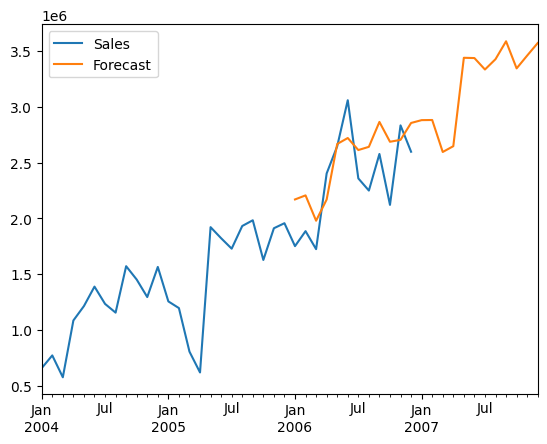

In [ ]:
df_a1 = forecast_agent_sarimax("Alabama Agent1",(0, 1, 1, 1, 1, 1, 12))
df_a1_d = decompose_product_forecast(df_a1, "Alabama Agent1")

In [ ]:
df_a1

,Sales,Forecast,Difference
2004-01-01,659308,0,NaN
2004-02-01,772917,0,NaN
2004-03-01,577161,0,NaN
2004-04-01,1085866,0,NaN
2004-05-01,1214758,0,NaN
2004-06-01,1389002,0,NaN
2004-07-01,1234437,0,NaN
2004-08-01,1155977,0,NaN
2004-09-01,1571831,0,NaN
2004-10-01,1452144,0,NaN


<Axes: >

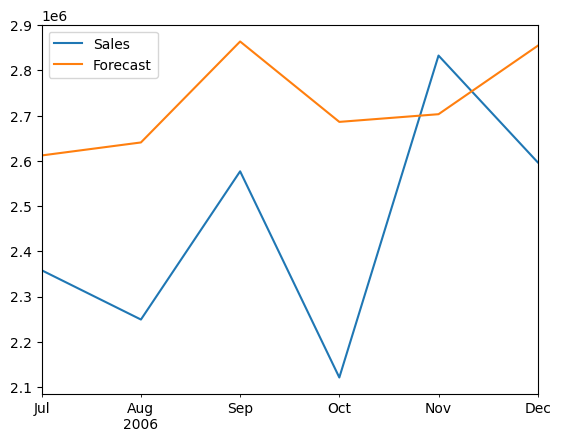

In [ ]:
df_a1.iloc[30:36,0:2].plot()

**Decomposition of forecast for product sales (sold by Alabama agent 1)**

In [ ]:
df_a1_d

,Date,ProductCode,ProductForecast
0,2006-01-01,15645,3254.3175
1,2006-01-01,16220,2386.4995
2,2006-01-01,17240,3037.3630
3,2006-01-01,19875,867.8180
4,2006-01-01,19920,3905.1810
...,...,...,...
739,2007-12-01,95945,0.0000
740,2007-12-01,96500,2499.1400
741,2007-12-01,97533,0.0000
742,2007-12-01,98669,0.0000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  32.0%


,Sales,Forecast,Difference
2004-01-01,352282,0,NaN
2004-02-01,303969,0,NaN
2004-03-01,262440,0,NaN
2004-04-01,418853,0,NaN
2004-05-01,578918,0,NaN
2004-06-01,666389,0,NaN
2004-07-01,734094,0,NaN
2004-08-01,527810,0,NaN
2004-09-01,835009,0,NaN
2004-10-01,776429,0,NaN


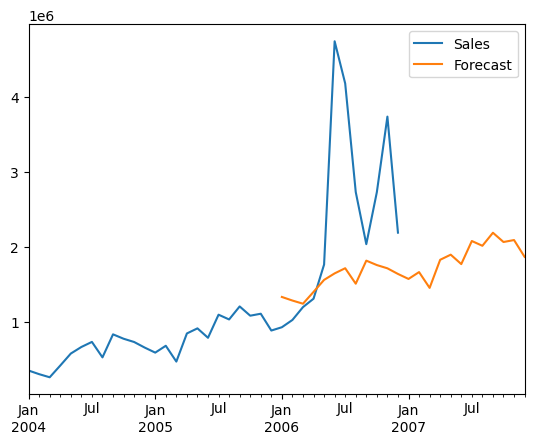

In [ ]:
df_a2 = forecast_agent_sarimax("Alabama Agent2",(0, 1, 1, 1, 1, 1, 12))
df_a2

<Axes: >

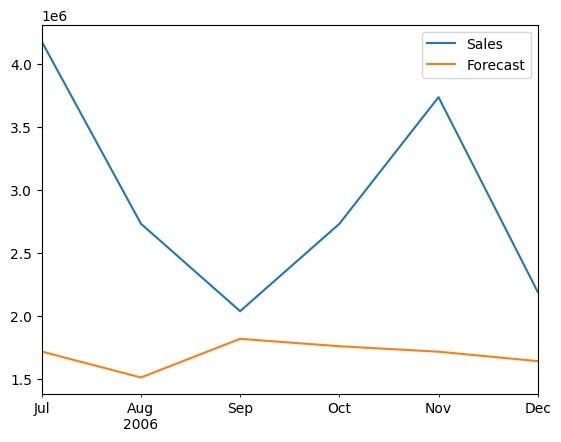

In [ ]:
df_a2.iloc[30:36,0:2].plot()

In [ ]:
import numpy as np

# Actual sales and forecasted sales values for AA2
actual_sales = [4180796, 2732678, 2037531, 2731440, 3738507, 2190940]
forecasted_sales = [171663, 1510391, 1817798, 1758873, 1715563, 1640514]

# Calculate error
errors = [actual - forecasted for actual, forecasted in zip(actual_sales, forecasted_sales)]

# Calculate absolute percentage error
absolute_percentage_errors = [abs(error / actual) * 100 for error, actual in zip(errors, actual_sales)]

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(absolute_percentage_errors)

# Calculate accuracy
accuracy = 100 - mape

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Accuracy: {:.2f}%".format(accuracy))

Mean Absolute Percentage Error (MAPE): 44.37%
Accuracy: 55.63%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  8.0%


,Sales,Forecast,Difference
2004-01-01,268301,0,NaN
2004-02-01,211287,0,NaN
2004-03-01,206552,0,NaN
2004-04-01,265340,0,NaN
2004-05-01,331725,0,NaN
2004-06-01,324659,0,NaN
2004-07-01,389564,0,NaN
2004-08-01,375446,0,NaN
2004-09-01,384631,0,NaN
2004-10-01,430313,0,NaN


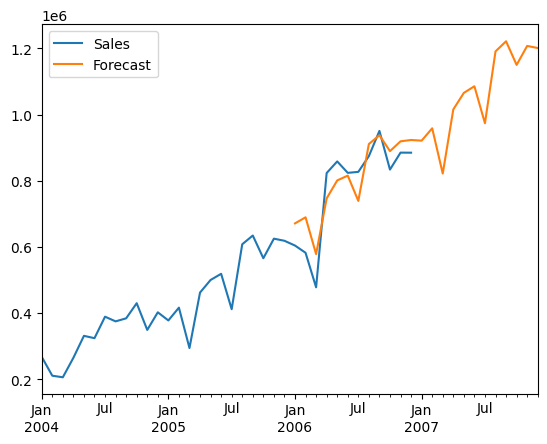

In [ ]:
df_a3 = forecast_agent_sarimax("Alabama Agent3",(1, 1, 1, 1, 1, 4, 12))
df_a3

<Axes: >

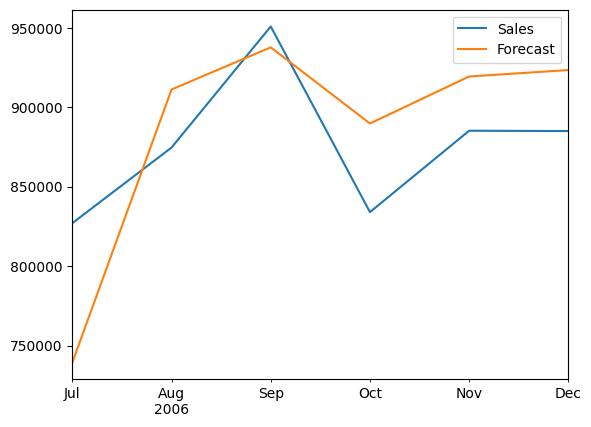

In [ ]:
df_a3.iloc[30:36,0:2].plot()

In [ ]:
import numpy as np

# Actual sales and forecasted sales values for AA3
actual_sales = [827046, 874615, 950787, 833984, 885197, 884989]
forecasted_sales = [739335, 911147, 937684, 889729, 919330, 923377]

# Calculate error
errors = [actual - forecasted for actual, forecasted in zip(actual_sales, forecasted_sales)]

# Calculate absolute percentage error
absolute_percentage_errors = [abs(error / actual) * 100 for error, actual in zip(errors, actual_sales)]

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(absolute_percentage_errors)

# Calculate accuracy
accuracy = 100 - mape

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Accuracy: {:.2f}%".format(accuracy))

Mean Absolute Percentage Error (MAPE): 5.17%
Accuracy: 94.83%


**Forecasting for Alabama branch.**

In [ ]:
df_alabama = df_a1[["Forecast"]].copy()
df_alabama["Forecast"] = df_a1["Forecast"] + df_a2["Forecast"] + df_a3["Forecast"]
df_alabama = df_alabama[df_alabama["Forecast"] > 0]
df_alabama

,Forecast
2006-01-01,4174525
2006-02-01,4181393
2006-03-01,3801214
2006-04-01,4316812
2006-05-01,5028472
2006-06-01,5183359
2006-07-01,5067883
2006-08-01,5062182
2006-09-01,5619314
2006-10-01,5334708


**Forecasting for Florida C&F agents**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  13.0%


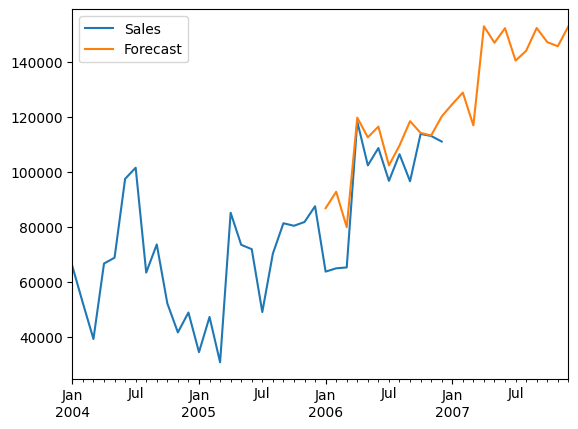

In [ ]:
df_f1 = forecast_agent_sarimax("Florida Agent1",(0, 1, 1, 1, 1, 1, 12))
df_f1_d = decompose_product_forecast(df_f1, "Florida Agent1")

In [ ]:
df_f1

,Sales,Forecast,Difference
2004-01-01,65686,0,NaN
2004-02-01,52254,0,NaN
2004-03-01,39230,0,NaN
2004-04-01,66655,0,NaN
2004-05-01,68785,0,NaN
2004-06-01,97439,0,NaN
2004-07-01,101488,0,NaN
2004-08-01,63376,0,NaN
2004-09-01,73609,0,NaN
2004-10-01,52176,0,NaN


**Decomposition of forecast for product sales (sold by Florida agent 1)**

In [ ]:
df_f1_d

,Date,ProductCode,ProductForecast
0,2006-01-01,15645,34.7096
1,2006-01-01,16220,8.6774
2,2006-01-01,17240,34.7096
3,2006-01-01,19875,26.0322
4,2006-01-01,19920,112.8062
...,...,...,...
739,2007-12-01,95945,0.0000
740,2007-12-01,96500,259.8059
741,2007-12-01,97533,0.0000
742,2007-12-01,98669,0.0000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  26.0%


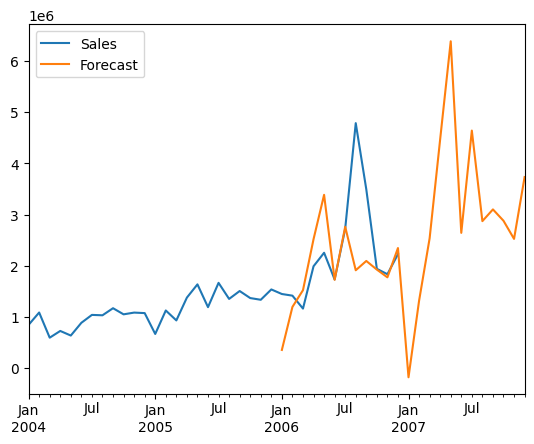

In [ ]:
df_f2=forecast_agent_sarimax("Florida Agent2",(0, 0, 0, 1, 5, 5, 12))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  26.0%


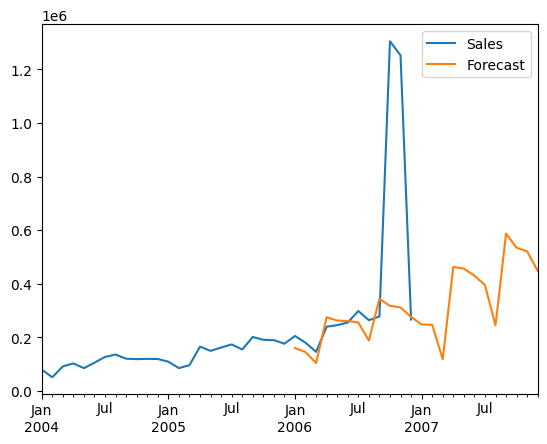

In [ ]:
df_f3=forecast_agent_sarimax("Florida Agent3",(0, 0, 0, 0, 5, 5, 12))

**Forecasting for Florida Branch**

In [ ]:
df_florida = df_f1[["Forecast"]].copy()
df_florida["Forecast"] = df_f1["Forecast"] + df_f2["Forecast"] + df_f3["Forecast"]
df_florida = df_florida[df_florida["Forecast"] > 0]
df_florida

,Forecast
2006-01-01,600135
2006-02-01,1431244
2006-03-01,1705573
2006-04-01,2912349
2006-05-01,3761274
2006-06-01,2101955
2006-07-01,3119136
2006-08-01,2208249
2006-09-01,2554584
2006-10-01,2355676


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([1]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for January 2006:", total_sales_value)


Total sales value for Alabama Branch for January 2006: 3285763


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([2]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for Feb 2006:", total_sales_value)


Total sales value for Alabama Branch for Feb 2006: 3495255


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([3]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for March 2006:", total_sales_value)


Total sales value for Alabama Branch for March 2006: 3400943


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([4]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for April 2006:", total_sales_value)


Total sales value for Alabama Branch for April 2006: 4536041


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([5]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for May 2006:", total_sales_value)


Total sales value for Alabama Branch for May 2006: 5270481


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([6]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for June 2006:", total_sales_value)


Total sales value for Alabama Branch for June 2006: 8625500


In [ ]:
import pandas as pd



# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for "Alabama Branch" and the specified months in 2006
filter_condition = (df['BranchLocation'] == 'Alabama BRANCH') & \
                   (df['Date'].dt.year == 2006) & \
                   (df['Date'].dt.month.isin([1]))

filtered_df = df[filter_condition]

# Calculate total sales value
total_sales_value = filtered_df['Sales'].sum()

print("Total sales value for Alabama Branch for January 2006:", total_sales_value)


Total sales value for Alabama Branch for January 2006: 3285763


**Forecasting for Louisiana C&F agents**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE:  12.0%


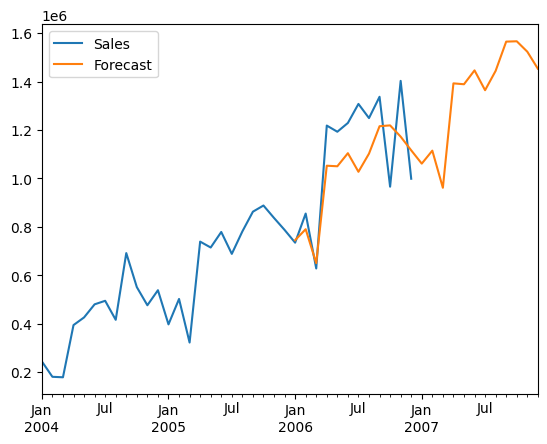

In [ ]:
df_l1 = forecast_agent_sarimax("Louisiana Agent1",(1, 1, 1, 1, 1, 2, 12))
df_ll_d = decompose_product_forecast(df_l1, "Louisiana Agent1")

**Decomposition of forecast for product sales (sold by Louisiana agent 1)**

In [ ]:
df_ll_d

,Date,ProductCode,ProductForecast
0,2006-01-01,15645,447.1650
1,2006-01-01,16220,149.0550
2,2006-01-01,17240,74.5275
3,2006-01-01,19875,372.6375
4,2006-01-01,19920,1117.9125
...,...,...,...
739,2007-12-01,95945,0.0000
740,2007-12-01,96500,1162.5632
741,2007-12-01,97533,0.0000
742,2007-12-01,98669,0.0000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE:  24.0%


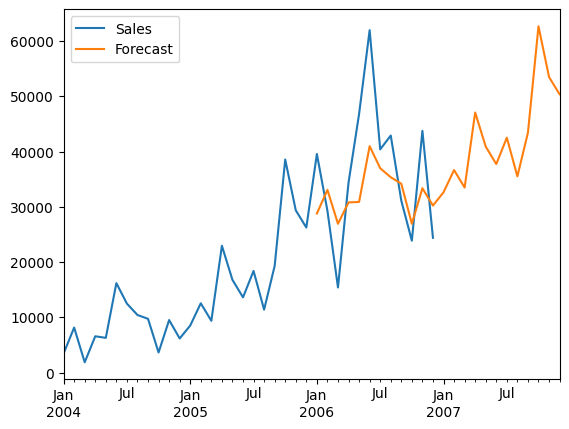

In [ ]:
df_l2= forecast_agent_sarimax("Louisiana Agent2",(1, 1, 1, 1, 1, 1, 12))


**Forecasting fo Louisiana Branch**

In [ ]:
df_louisiana = df_l1[["Forecast"]].copy()
df_louisiana["Forecast"] = df_l1["Forecast"] + df_l2["Forecast"]
df_louisiana = df_louisiana[df_louisiana["Forecast"] > 0]
df_louisiana

,Forecast
2006-01-01,774060
2006-02-01,823646
2006-03-01,677284
2006-04-01,1083490
2006-05-01,1081288
2006-06-01,1145343
2006-07-01,1064610
2006-08-01,1137911
2006-09-01,1249919
2006-10-01,1246099


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE:  24.0%


,Sales,Forecast,Difference
2004-01-01,3435,0,NaN
2004-02-01,8150,0,NaN
2004-03-01,1863,0,NaN
2004-04-01,6569,0,NaN
2004-05-01,6283,0,NaN
2004-06-01,16187,0,NaN
2004-07-01,12475,0,NaN
2004-08-01,10424,0,NaN
2004-09-01,9725,0,NaN
2004-10-01,3638,0,NaN


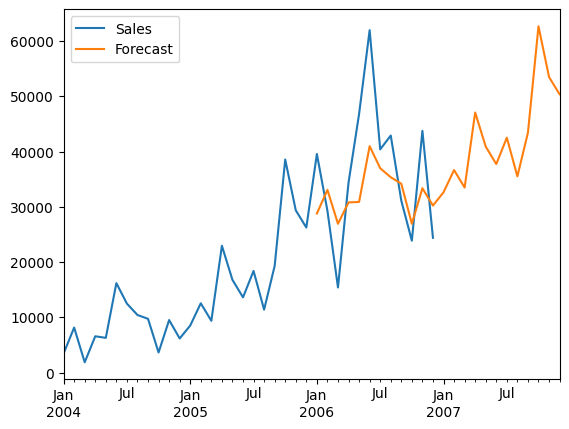

In [ ]:
forecast_agent_sarimax("Louisiana Agent2",(1, 1, 1, 1, 1, 1, 12))